In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('/content/drive/MyDrive/drug200.csv')

In [3]:
# Encode categorical features
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == object:
        df[column] = le.fit_transform(df[column])

In [4]:
X = df.drop("Drug", axis=1).values
y = df["Drug"].values

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _best_split(self, X, y):
        m, n = X.shape
        best_gain = 0
        split_idx, split_thresh = None, None
        parent_entropy = self._entropy(y)

        for i in range(n):
            thresholds = np.unique(X[:, i])
            for t in thresholds:
                left_idx = X[:, i] <= t
                right_idx = X[:, i] > t
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                left_entropy = self._entropy(y[left_idx])
                right_entropy = self._entropy(y[right_idx])
                gain = parent_entropy - (len(y[left_idx]) / len(y) * left_entropy + len(y[right_idx]) / len(y) * right_entropy)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = i
                    split_thresh = t
        return split_idx, split_thresh

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return leaf_value

        feat_idx, threshold = self._best_split(X, y)
        if feat_idx is None:
            return self._most_common_label(y)

        left_idx = X[:, feat_idx] <= threshold
        right_idx = X[:, feat_idx] > threshold
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return (feat_idx, threshold, left, right)

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def _traverse_tree(self, x, node):
        if not isinstance(node, tuple):
            return node
        feat_idx, threshold, left, right = node
        if x[feat_idx] <= threshold:
            return self._traverse_tree(x, left)
        else:
            return self._traverse_tree(x, right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])


In [7]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_preds)


In [8]:
rf = RandomForest(n_estimators=5, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        15

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



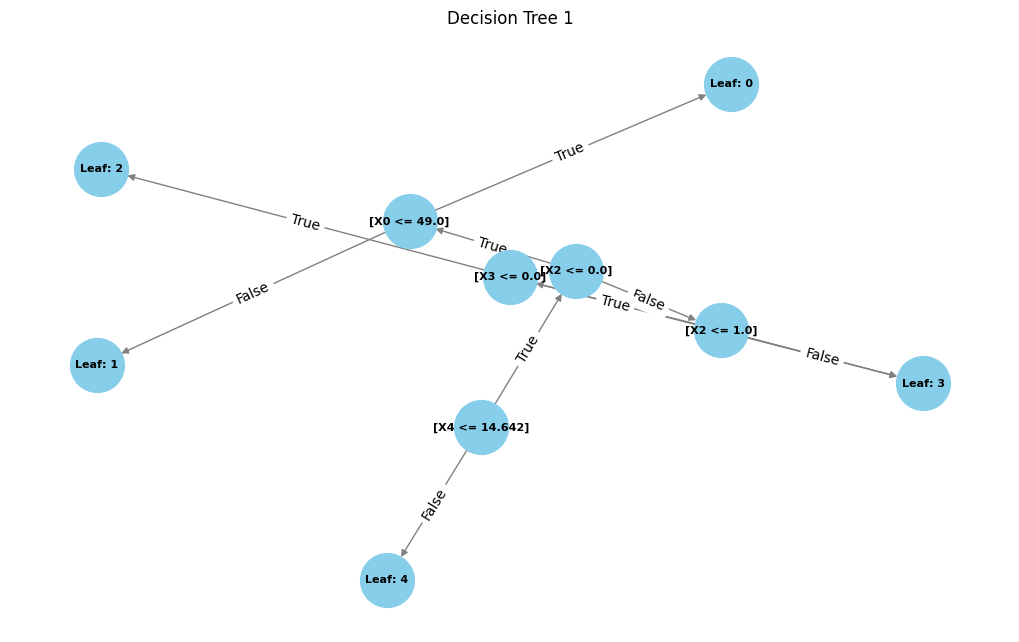

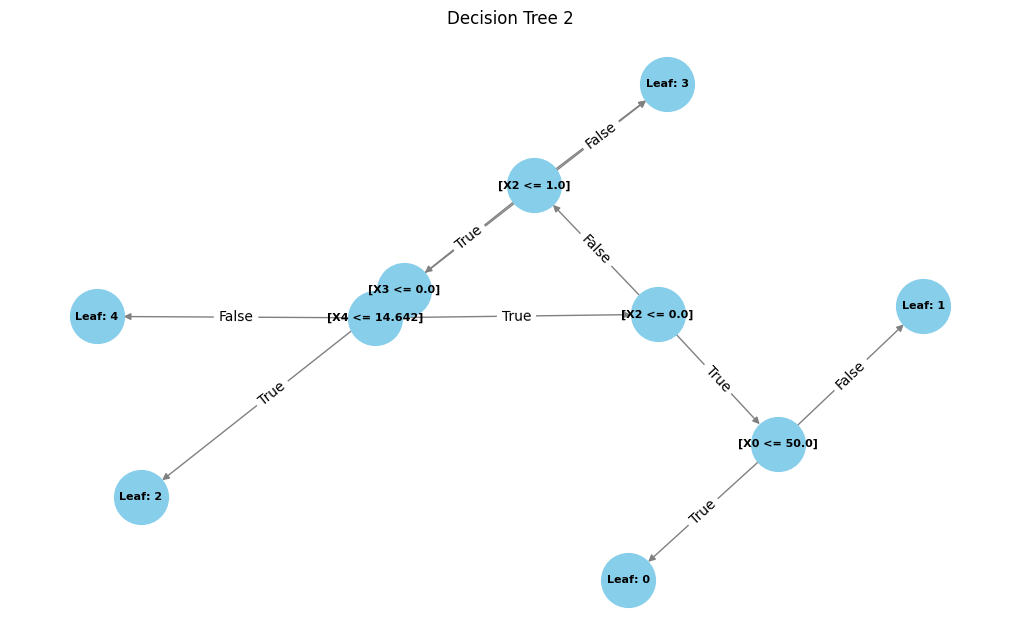

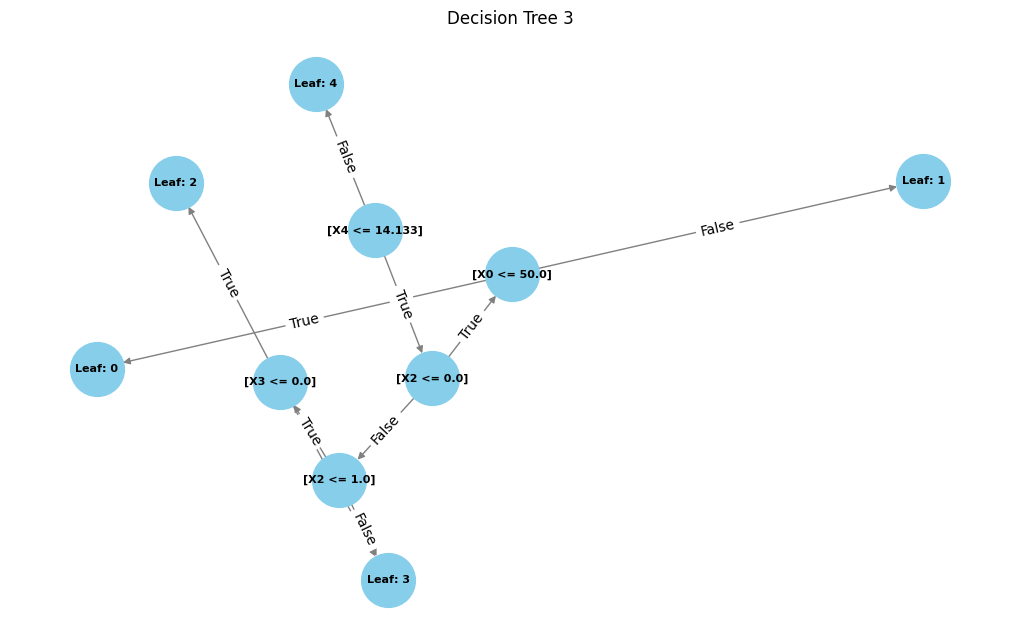

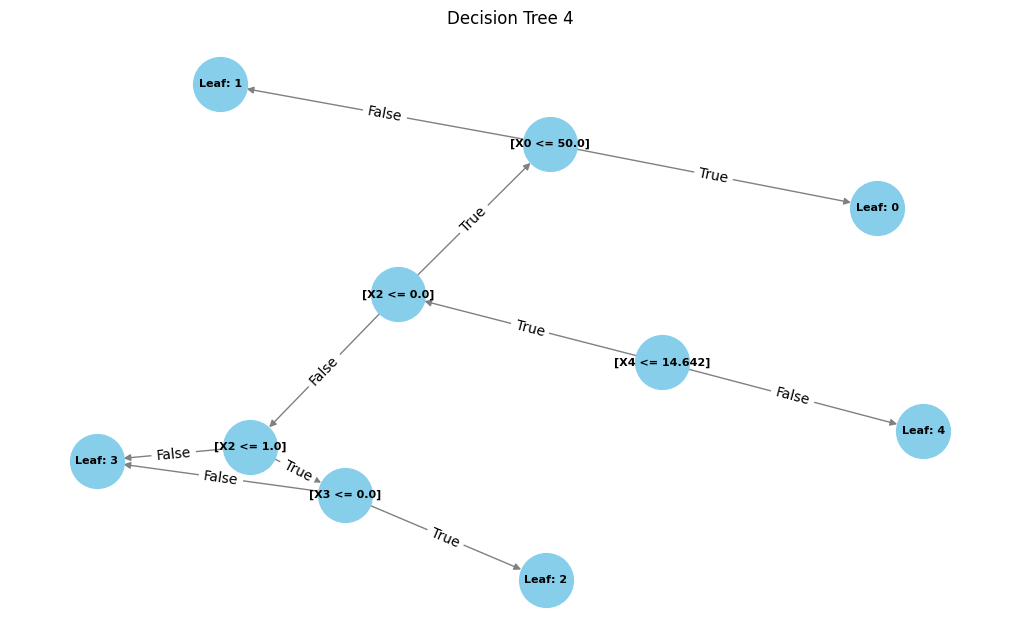

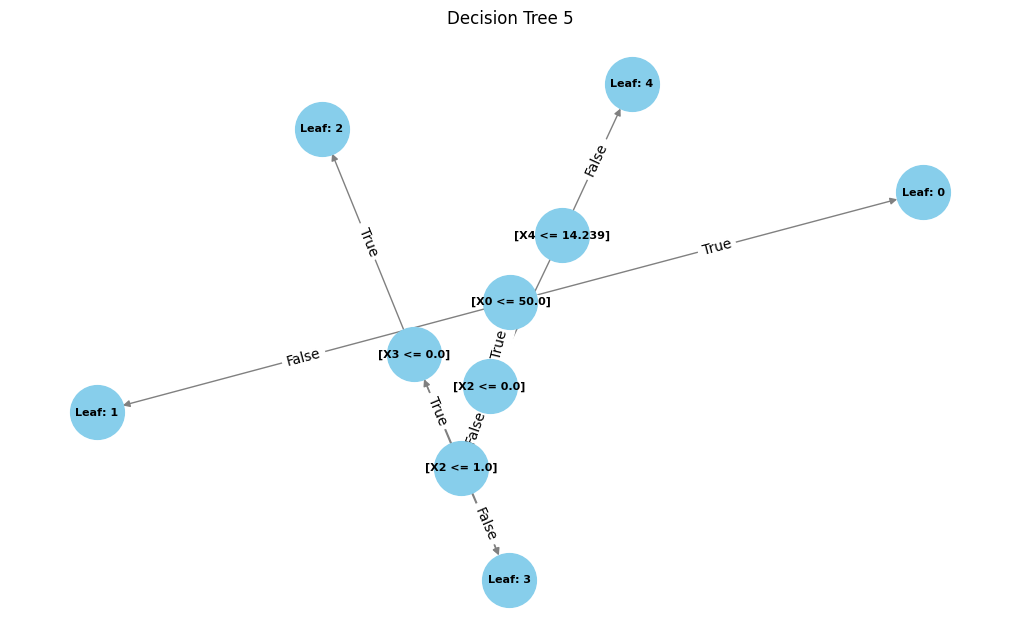

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_tree(node, graph, parent=None, edge_label=''):
    if not isinstance(node, tuple):
        node_label = f"Leaf: {node}"
        graph.add_node(node_label)
        if parent:
            graph.add_edge(parent, node_label, label=edge_label)
        return

    feat_idx, threshold, left, right = node
    node_label = f"[X{feat_idx} <= {threshold}]"
    graph.add_node(node_label)
    if parent:
        graph.add_edge(parent, node_label, label=edge_label)

    draw_tree(left, graph, node_label, 'True')
    draw_tree(right, graph, node_label, 'False')

for i, tree in enumerate(rf.trees):
    G = nx.DiGraph()
    draw_tree(tree.tree, G)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=8, font_weight='bold', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f"Decision Tree {i+1}")
    plt.show()


In [10]:
hyperparams = [
    {'n_estimators': 3, 'max_depth': 3, 'min_samples_split': 2},
    {'n_estimators': 5, 'max_depth': 4, 'min_samples_split': 2},
    {'n_estimators': 7, 'max_depth': 6, 'min_samples_split': 3},
    {'n_estimators': 10, 'max_depth': 8, 'min_samples_split': 4}
]

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_rf(X_train, X_test, y_train, y_test, n_estimators, max_depth, min_samples_split):
    print(f"\n=== Random Forest with n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split} ===")

    rf = RandomForest(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return rf

# Evaluate each hyperparameter configuration
forests = []
for params in hyperparams:
    rf_model = evaluate_rf(X_train, X_test, y_train, y_test,
                           params['n_estimators'],
                           params['max_depth'],
                           params['min_samples_split'])
    forests.append((params, rf_model))



=== Random Forest with n_estimators=3, max_depth=3, min_samples_split=2 ===
Accuracy: 0.8750
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       0.00      0.00      0.00         5
           3       0.69      1.00      0.81        11
           4       1.00      1.00      1.00        15

    accuracy                           0.88        40
   macro avg       0.74      0.80      0.76        40
weighted avg       0.79      0.88      0.82        40


=== Random Forest with n_estimators=5, max_depth=4, min_samples_split=2 ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 1.0000
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        15

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


=== Random Forest with n_estimators=7, max_depth=6, min_samples_split=3 ===
Accuracy: 1.0000
Confusion Matrix:
 [[ 6  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00

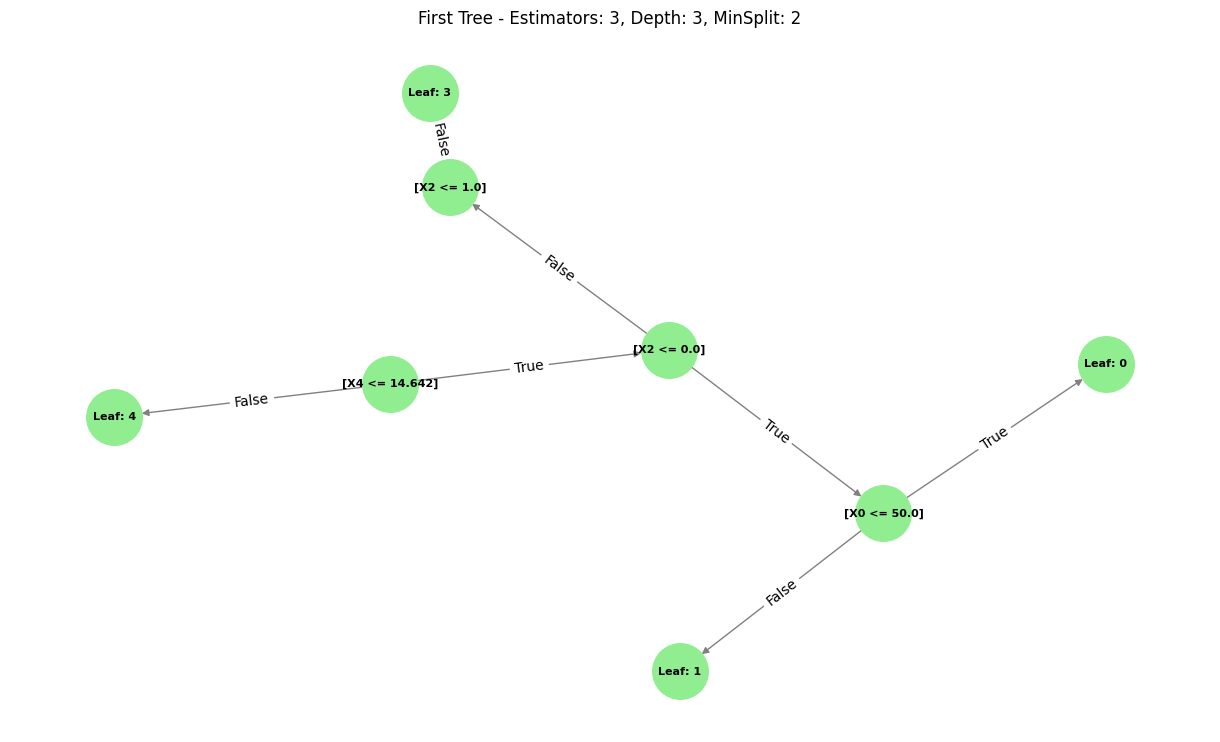

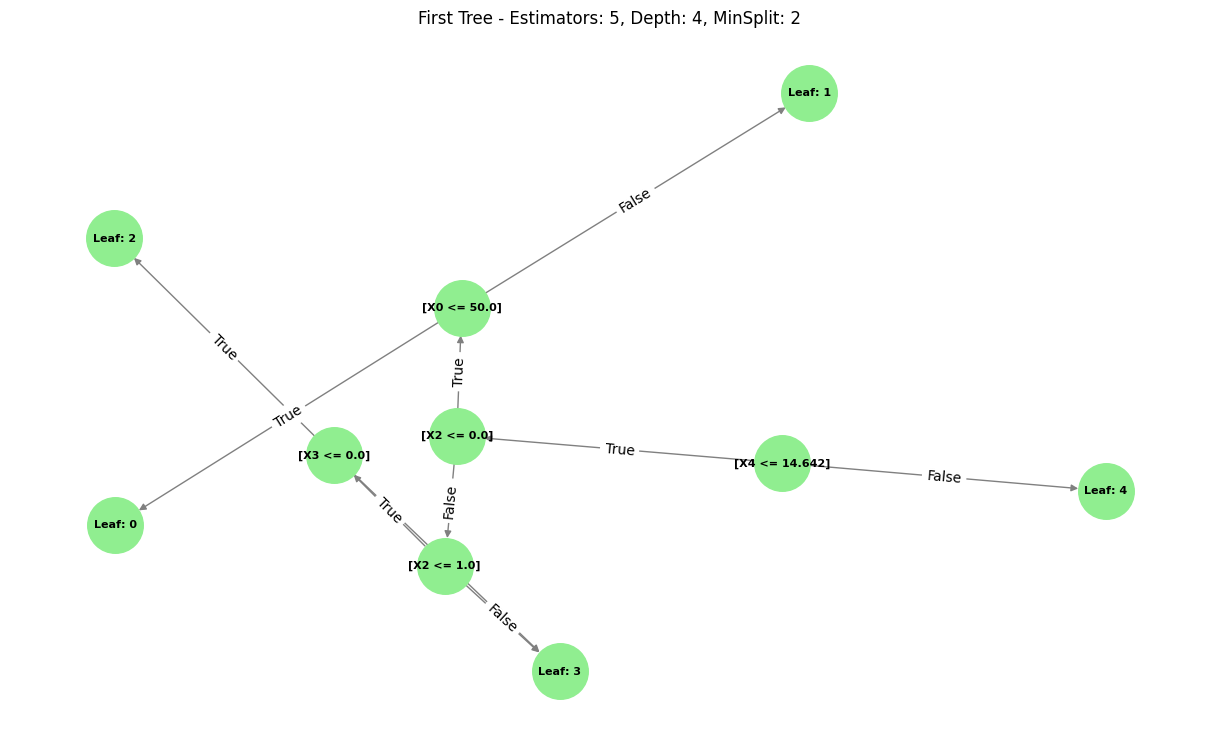

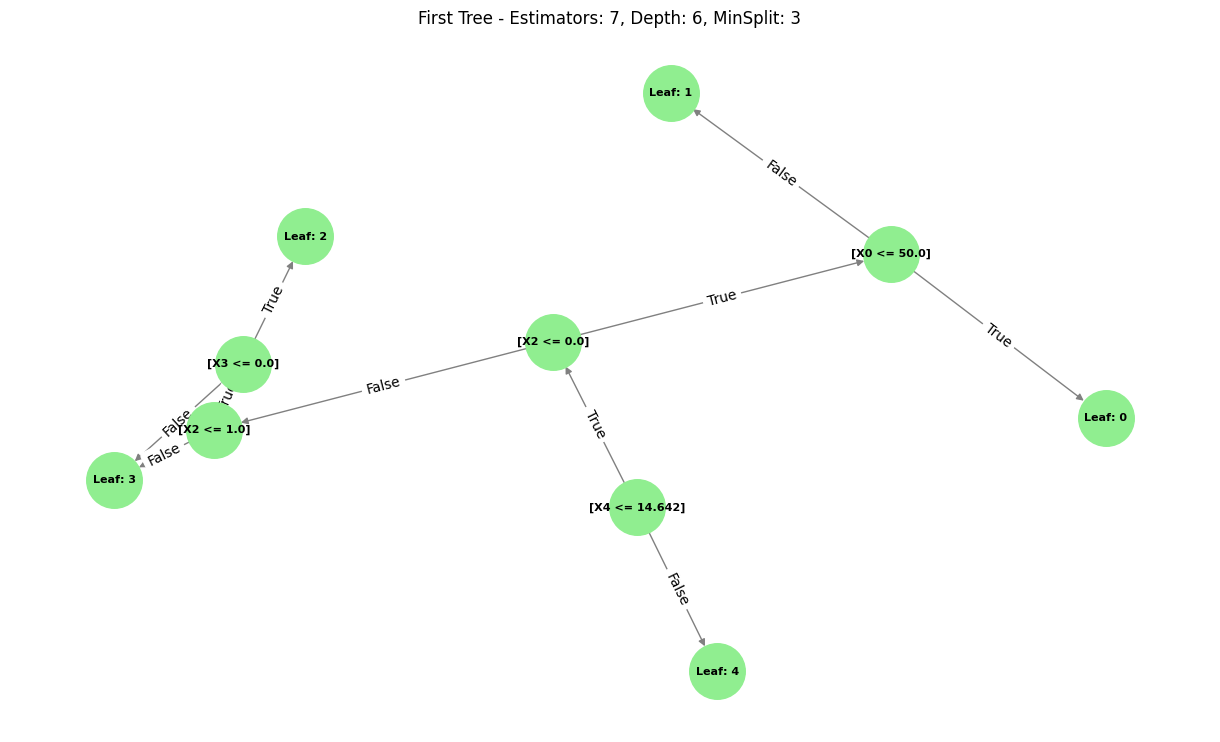

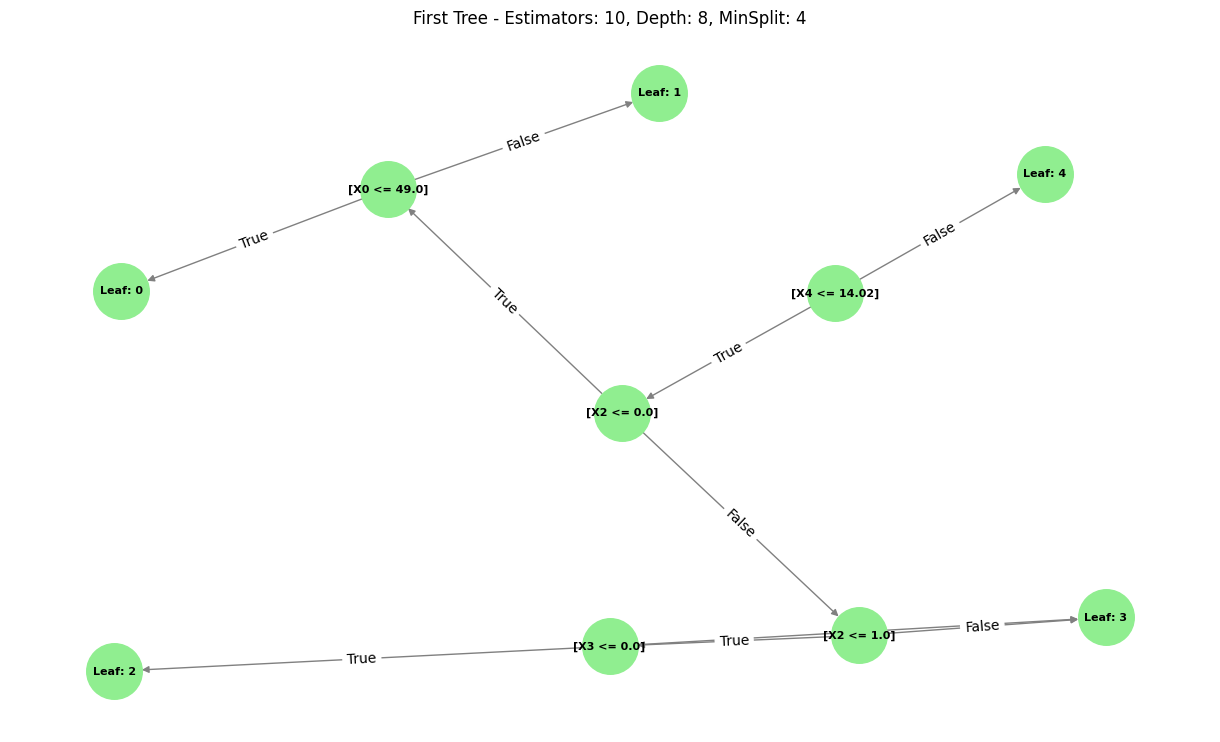

In [11]:
def plot_tree(tree, title="Tree"):
    G = nx.DiGraph()
    draw_tree(tree.tree, G)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 7))
    nx.draw(G, pos, with_labels=True, node_size=1600, node_color='lightgreen', font_size=8, font_weight='bold', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

# Plot first tree of each forest
for (params, forest) in forests:
    plot_tree(forest.trees[0], title=f"First Tree - Estimators: {params['n_estimators']}, Depth: {params['max_depth']}, MinSplit: {params['min_samples_split']}")
